In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import DiscountingCurve, EquityForwardCurve, Black,ForwardVariance,Vanilla_PayOff
from montecarlo import MC
import lets_be_rational.LetsBeRational as lbr
from closedforms import d1, European_closed_form, Delta, StrikeFromDelta
import scipy.stats as si
import time, sys
from scipy import log, sqrt, exp

In [2]:
r = 1/100
ref = 0
sigma = 20/100
spot_price = 150
data_times = np.array([1.,10.])

In [3]:
r = np.ones(len(data_times))*r
d = exp(-r*data_times)
D = DiscountingCurve(reference=0, discounts=d, dates=data_times)
F = EquityForwardCurve(reference=0,discounting_curve=D,spot=spot_price,repo_rates=[0,0],repo_dates=data_times)

Forward zero rate:  [0.01 0.01]


In [4]:
K = np.array([spot_price,200])
spot_vol = np.array(([sigma,sigma],[0.3,0.3]))

V = ForwardVariance(reference=0,maturities=data_times,strikes=K,spot_volatility=spot_vol,strike_interp=spot_price)

Forward volatility:  [0.2 0.2]


In [5]:
maturities = np.arange(1,31)*0.15
model = Black(forward_curve=F,variance=V)
S_t = model.simulate(fixings=maturities,Nsim=1e6, seed=11)
X_t = S_t/F(maturities)
E_X,err_E_X = MC(X_t)

Single Asset Simulation


In [6]:
kind = -1
logmoneyness =np.arange(-10,11)*0.1
K1 =spot_price* np.exp(logmoneyness[0])
print(K1)
option = Vanilla_PayOff(St=X_t, strike=K1/F(maturities),typo=kind)
result, errore = MC(option)

K2 = spot_price* np.exp(logmoneyness[10])
print(K2)
option = Vanilla_PayOff(St=X_t, strike=K2/F(maturities),typo=kind)
result2, errore2 = MC(option)

kind=1
K3 = spot_price* np.exp(logmoneyness[len(logmoneyness)-1])
print(K3)
option = Vanilla_PayOff(St=X_t, strike=K3/F(maturities),typo=kind)
result3, errore3 = MC(option)


55.18191617571635
150.0
407.74227426885676


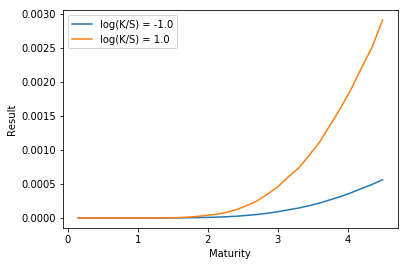

In [7]:
plt.plot(maturities, result, label = "log(K/S) = "+str(logmoneyness[0]))
#plt.plot(maturities, result4, label = "log(S/K) = "+str(logmoneyness[10]))
plt.plot(maturities, result3, label = "log(K/S) = "+str(logmoneyness[len(logmoneyness)-1]))
plt.xlabel("Maturity")
plt.ylabel("Result")
plt.legend()
#plt.savefig("Normalized_price_error.pdf")

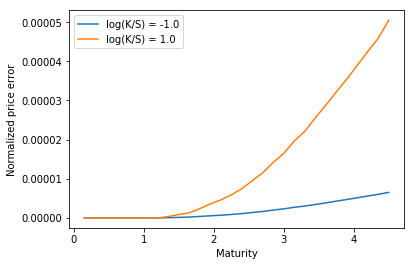

In [8]:
plt.plot(maturities, errore, label = "log(K/S) = "+str(logmoneyness[0]))
#plt.plot(maturities, errore2, label = "log(S/K) = "+str(logmoneyness[10]))
plt.plot(maturities, errore3, label = "log(K/S) = "+str(logmoneyness[len(logmoneyness)-1]))
plt.legend()
plt.xlabel("Maturity")
plt.ylabel("Normalized price error")
#plt.savefig("Normalized_price_error.pdf")
plt.show()

### Results in terms of log Moneyness log(S/K)

In [9]:
kind = -1
logmoneyness =np.arange(-10,11)*0.1
imp_volatility = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_plus = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_minus = np.zeros((len(logmoneyness),len(maturities)))
X_t = S_t/F(maturities)
E_X,err_E_X = MC(X_t)
start_time = time.time()
for i in range(len(logmoneyness)):
    if i%10 == 0:
        print("Running: ",i,"%")
    for j in range(len(maturities)):
        if logmoneyness[i]>=0.:
            kind =1
        elif logmoneyness[i]<0.:
            kind =-1
        K = F(maturities[j])* np.exp(logmoneyness[i])
    
        option = Vanilla_PayOff(St=X_t, strike=K/F(maturities),typo=kind)
        result, err_result = MC(option)
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],1,K/F(maturities[j]),maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],1,K/F(maturities[j]),maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],1,K/F(maturities[j]),maturities[j],kind)
        
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
np.savetxt("Results_moneyness_forward/norm_implied_volatility_mean_log.txt",imp_volatility)    #saving results
np.savetxt("Results_moneyness_forward/norm_implied_volatility_minus_log.txt",imp_volatility_minus)    #saving results
np.savetxt("Results_moneyness_forward/norm_implied_volatility_plus_log.txt",imp_volatility_plus)    #saving results
np.savetxt("Results_moneyness_forward/norm_moneyness_log.txt",logmoneyness)
np.savetxt("Results_moneyness_forward/norm_maturities_log.txt",maturities)
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Execution time: ---27.631278491020204 min ---
Saving_Files...
COMPLETED


In [ ]:
logmoneyness = np.loadtxt("Results_moneyness_forward/norm_moneyness_log.txt")
maturities = np.loadtxt("Results_moneyness_forward/norm_maturities_log.txt")
imp_volatility = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_mean_log.txt")
imp_volatility_plus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_plus_log.txt")
imp_volatility_minus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_minus_log.txt")

In [13]:
y_lower = np.zeros((len(logmoneyness),len(maturities)))
y_upper = np.zeros((len(logmoneyness),len(maturities)))
counter = 0
for i in range(len(logmoneyness)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])
            #if(y_lower[i][j]>100):
             #   y_lower[i][j] = y_upper[i][j]
            #if(y_upper[i][j]>100):
             #   y_upper[i][j] = y_lower[i][j]
            #if imp_volatility[i][j]<-100:
              #  imp_volatility[i][j] = None
          


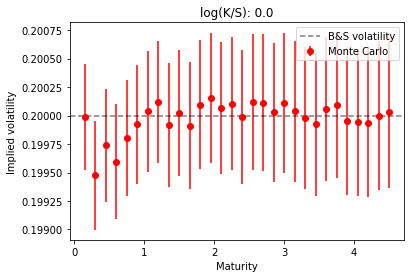

In [14]:
"""Fixed Strike"""  #ATM = 5
num = [10]    # 0, 5, 15
c=2
for i in range(len(num)):
    err_lower = 2*y_lower[num[i]]
    err_upper = 2*y_upper[num[i]]
    plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "red",label="Monte Carlo")
    plt.title("log(K/F): "+str(round(logmoneyness[num[i]],c)))

plt.axhline(y=sigma, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
#plt.ylim(0.17,0.209)  #0
#plt.ylim(0.1947,0.2065) #15
#plt.ylim(0.14,0.235)  #39
plt.legend()
#plt.savefig("Graphs/implied_vol_logmoney"+str(round(logmoneyness[num[i]],c))+".pdf")
plt.show()

[0.00050544 0.00043751 0.0003896  0.00035629 0.00033367 0.00031923
 0.00031054 0.00030498 0.00029861 0.00028324 0.00066285 0.00061303
 0.00057936 0.00056111 0.00055811 0.00057109 0.00060182 0.00065401
 0.00073341 0.00085021 0.00101717]


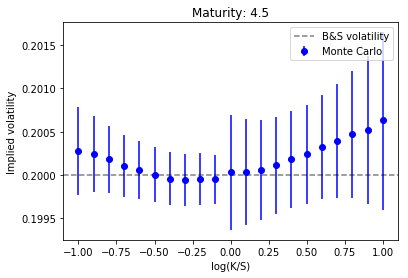

In [16]:
"""Fixed Maturity"""
num = [29]  #0, 6, 39
c=1
for i in range(len(num)):
    err_lower = 2*y_lower.T[num[i]]
    err_upper = 2*y_upper.T[num[i]]
    print(err_upper)
    plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="blue",label="Monte Carlo")
plt.axhline(y=sigma, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
#plt.ylim(0.195,0.202) #0
#plt.ylim(0.07,0.215) #6
plt.legend()
#plt.savefig("Graphs/implied_vol_logmaturity"+str(round(maturities[num[i]],c))+".pdf")
plt.show()

### Results in term of Delta

In [18]:
delta = np.arange(2,21)*0.05
delta

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [20]:
kind = -1
imp_volatility = np.zeros((len(delta),len(maturities)))
imp_volatility_plus = np.zeros((len(delta),len(maturities)))
imp_volatility_minus = np.zeros((len(delta),len(maturities)))
X_t = S_t/F(maturities)
E_X,err_E_X = MC(X_t)
start_time = time.time()
for j in range(len(maturities)):
    if j%10 == 0:
        print("Running: ",j,"%")
    for i in range(len(delta)):
        K = StrikeFromDelta(F,maturities[j],delta[i],sigma)
        if K >= F(maturities[j]):
            kind = 1  #1 buono
           # print("Sono una call")
        elif K<F(maturities[j]):
            kind = -1  #-1 buono
          #  print("Sono una put")
        option = Vanilla_PayOff(St=X_t, strike=K/F(maturities),typo=kind)
        result, err_result = MC(option)
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],E_X[j],K/F(maturities[j]),maturities[j],kind)

    
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
np.savetxt("Results_moneyness_forward/norm_implied_volatility_mean_delta.txt",imp_volatility)    #saving results
np.savetxt("Results_moneyness_forward/norm_implied_volatility_minus_delta.txt",imp_volatility_minus)    #saving results
np.savetxt("Results_moneyness_forward/norm_implied_volatility_plus_delta.txt",imp_volatility_plus)    #saving results
np.savetxt("Results_moneyness_forward/norm_moneyness_delta.txt",delta)
np.savetxt("Results_moneyness_forward/norm_maturities_delta.txt",maturities)
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Execution time: ---25.401083906491596 min ---
Saving_Files...
COMPLETED


In [ ]:
delta = np.loadtxt("Results_moneyness_forward/norm_moneyness_delta.txt")
maturities = np.loadtxt("Results_moneyness_forward/norm_maturities_delta.txt")
imp_volatility = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_mean_delta.txt")
imp_volatility_plus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_plus_delta.txt")
imp_volatility_minus = np.loadtxt("Results_moneyness_forward/norm_implied_volatility_minus_delta.txt")

In [22]:
y_lower = np.zeros((len(delta),len(maturities)))
y_upper = np.zeros((len(delta),len(maturities)))
counter = 0
for i in range(len(delta)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])
                
           # if(y_lower[i][j]>100):
            #    y_lower[i][j] = y_upper[i][j]
            #if(y_upper[i][j]>100):
             #   y_upper[i][j] = y_lower[i][j]
            if abs(imp_volatility[i][j])>100:
                imp_volatility[i][j] = None
          

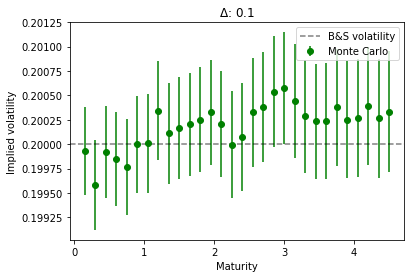

In [29]:
"""Fixed Strike"""  #ATM = 5
num = [0]    # 0, 5, 15
c=2
for i in range(len(num)):
    err_lower = 2*y_lower[num[i]]
    err_upper = 2*y_upper[num[i]]
    plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "green",label="Monte Carlo")
    plt.title("$\Delta$: "+str(round(delta[num[i]],c)))

plt.axhline(y=sigma, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
#plt.ylim(0.14,0.218)  #0
#plt.ylim(0.1947,0.2065) #15
#plt.ylim(0.14,0.235)  #39
plt.legend()
plt.savefig("Graphs/implied_vol_delta"+str(round(delta[num[i]],c))+".pdf")
plt.show()

[0.0006188  0.00057951 0.00056296 0.00055794 0.00056025 0.00056791
 0.00058011 0.00059654 0.00061723 0.00064258 0.00025392 0.00027554
 0.00029012 0.00029831 0.00030332 0.00030772 0.0003149  0.00033569
 0.        ]


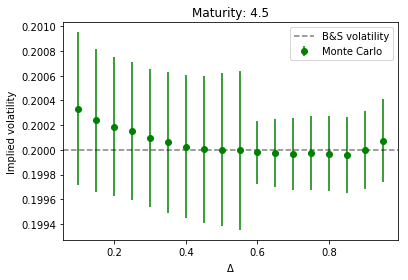

In [27]:
"""Fixed Maturity"""
num = [29]  #0, 6, 39
c=1
for i in range(len(num)):
    err_lower = 2*y_lower.T[num[i]]
    err_upper = 2*y_upper.T[num[i]]
    print(err_lower)
    plt.errorbar(delta,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="green",label="Monte Carlo")
plt.axhline(y=sigma, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("$\Delta$")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
#plt.ylim(0.185,0.202) #0
#plt.ylim(0.07,0.215) #6
plt.legend()
plt.savefig("Graphs/implied_vol_deltamaturity"+str(round(maturities[num[i]],c))+".pdf")
plt.show()

In [ ]:
StrikeFromDelta(F,1.5,0.4,0.2)

In [ ]:
np.savetxt("Results_moneyness/norm_implied_volatility_mean_deltaplus_minus.txt",imp_volatility)    #saving results
np.savetxt("Results_moneyness/norm_implied_volatility_minus_deltaplus_minus.txt",imp_volatility_minus)    #saving results
np.savetxt("Results_moneyness/norm_implied_volatility_plus_deltaplus_minus.txt",imp_volatility_plus)    #saving results
np.savetxt("Results_moneyness/norm_moneyness_deltaplus_minus.txt",delta)
np.savetxt("Results_moneyness/norm_maturities_deltaplus_minus.txt",maturities)

In [ ]:
r = 5/100
S = 100
T = 30/365
K = 100
F = S*np.exp(r*T)
C = 1

In [ ]:
lbr.implied_volatility_from_a_transformed_rational_guess(C/S,1,K/F,T,1)*100

In [ ]:
h = (K/F**2)
x = np.log(1/h)
beta = (C/S)/np.sqrt((F**2)*h)

In [ ]:
(lbr.normalised_implied_volatility_from_a_transformed_rational_guess(beta,x,1)/np.sqrt(T))*100

In [ ]:
kind = -1
moneyness = np.arange(1,20)*0.1
imp_volatility = np.zeros((len(moneyness),len(maturities)))
K =1
start_time = time.time()
for i in range(len(moneyness)):
    if moneyness[i]<1.:
        kind = -1
    elif moneyness[i]>=1.:
        kind = 1
    K = spot_price/moneyness[i]
    option = European_closed_form(spot_price, K, maturities, r, 0, sigma,kind)
    if i%10 == 0:
        print("Running: ",i,"%")
    for j in range(len(maturities)):
        x = np.log(F(maturities[j])/K)
        beta = option[j]/np.sqrt(F(maturities[j])*K)
        imp_volatility[i][j] = lbr.normalised_implied_volatility_from_a_transformed_rational_guess(beta,x,kind)/np.sqrt(maturities[j])
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
print("COMPLETED")

In [ ]:
"""Fixed Maturity"""
num = [39]  #0, 6, 39
c=1
for i in range(len(num)):
    plt.scatter(moneyness,imp_volatility.T[num[i]],color="BLUE",label="Monte Carlo")
plt.axhline(y=sigma, color = 'red',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("Moneyness S/K")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
#plt.ylim(0.185,0.202) #0
#plt.ylim(0.07,0.215) #6
plt.legend()
#plt.savefig("Graphs/implied_vol_maturity"+str(round(maturities[num[i]],c))+".pdf")
plt.show()

In [ ]:
S = spot_price
K = 320
r = 0.01
q = 0
sigma = 0.20
T = 11
#F = S* np.exp(r*T)
delta = Delta(S,K,T,r,q,sigma)
delta

In [ ]:
StrikeFromDelta(F,T,delta,sigma)

In [ ]:
Delta?